In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from statsmodels.tsa.arima_model import ARIMA

# Squash warning messages for cleaner output in the notebook
import warnings
warnings.showwarning = lambda *args, **kwargs: None

In [2]:
sys.path.insert(1, '../') #utils is in parent folder
import utils
import get_data

In [ ]:
# This is only needed when we run in a Jupyter notebook and the external files are changed
import importlib
importlib.reload(utils)
importlib.reload(get_data)

## Set up parameters for training

**Settings for each training job**

In [3]:
granularity = 'daily' # hourly, daily, monthly
horizon = 28 # ex. 48 hours, 28 days (4 weeks), 12 months

**Static settings**

In [4]:
data_folder = '..\data'
time_column_name = 'dtime'
target_column_name = 'nycdemand'
effective_target_column = target_column_name
csvfile = os.path.join(data_folder, target_column_name + '_' + granularity + '.csv') # AutoML will compute lags automatically

# plot config
default_org_color = utils.default_org_color
default_trans_color = utils.default_trans_color
default_figsize = utils.default_figsize
default_rotation = utils.default_rotation

## Read in target timeseries, and set up training/testing data

In [5]:
df = pd.read_csv(csvfile, header=0, index_col=0, parse_dates=True).dropna()
df.head()

,nycdemand,nycdemand_lag1,nycdemand_lag2
dtime,,,
2012-01-03,146292.3,127270.9,118916.0
2012-01-04,152070.4,146292.3,127270.9
2012-01-05,147125.9,152070.4,146292.3
2012-01-06,140820.9,147125.9,152070.4
2012-01-07,124258.6,140820.9,147125.9


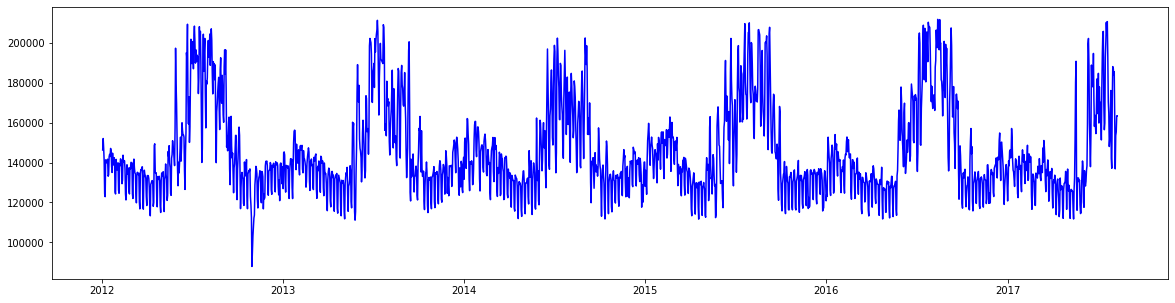

In [7]:
plt.figure(figsize=default_figsize)
plt.plot(df[target_column_name], color=default_org_color) 
plt.show()

In [8]:
min_time = df.index.min()
max_time = df.index.max()

In [9]:
delta, frequency, training_slice_begin, training_slice_end, test_slice_begin, test_slice_end = \
    get_data.split_train_test_by_granularity(granularity, horizon, min_time, max_time)

print('train between %s and %s, forecast between %s and %s' % \
      (training_slice_begin, training_slice_end, test_slice_begin, test_slice_end))

train between 2015-07-15 00:00:00 and 2017-07-13 00:00:00, forecast between 2017-07-14 00:00:00 and 2017-08-10 00:00:00


In [10]:
# For ARIMA, we don't use computed lag columns
dfall = df.loc[training_slice_begin:test_slice_end, [target_column_name]]
dftrain = df.loc[training_slice_begin:training_slice_end, [target_column_name]]
dftest = df.loc[test_slice_begin:test_slice_end, [target_column_name]]

## Test stationarity
A timeseries is stationary if its mean, variance (magnitude of change), and covariance (frequency of change) are constant over time. In order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

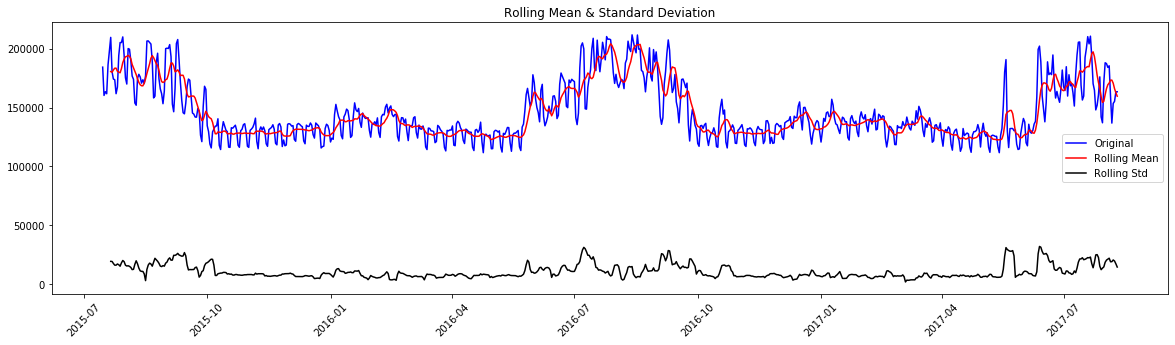

Results of Dickey-Fuller Test:
Test Statistic                  -2.354480
p-value                          0.154998
#Lags Used                      20.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


In [11]:
# If p-value is smaller than a significance level (typically 0.05, then the data is stationary)
# Or,
# If test statistics is smaller than critical values, then data is stationary. 
#   If test statistics is smaller than critical value at 1%, then we are 99% confident data is stationary
#   If test statistics is smaller than critical value at 5%, then we are 95% confident data is stationary
utils.test_stationarity(dfall[target_column_name], freq=frequency)

**Do the following cells only if data is not stationary**

**-------------------------------------------------------------------------------------**

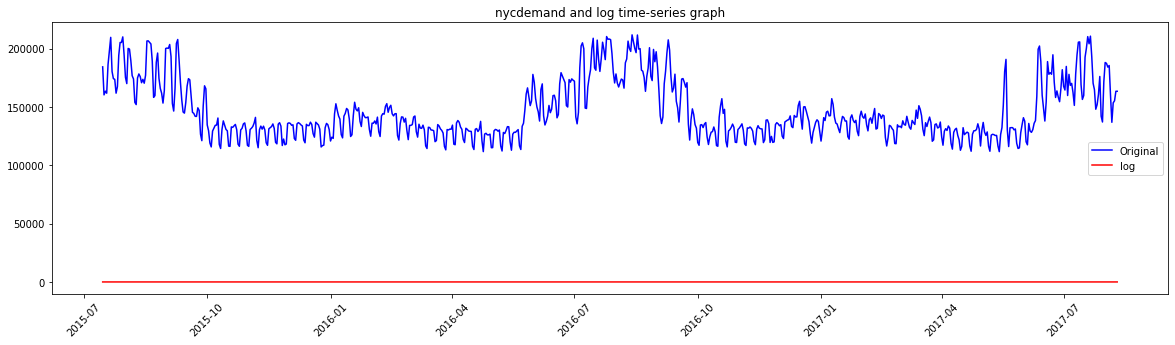

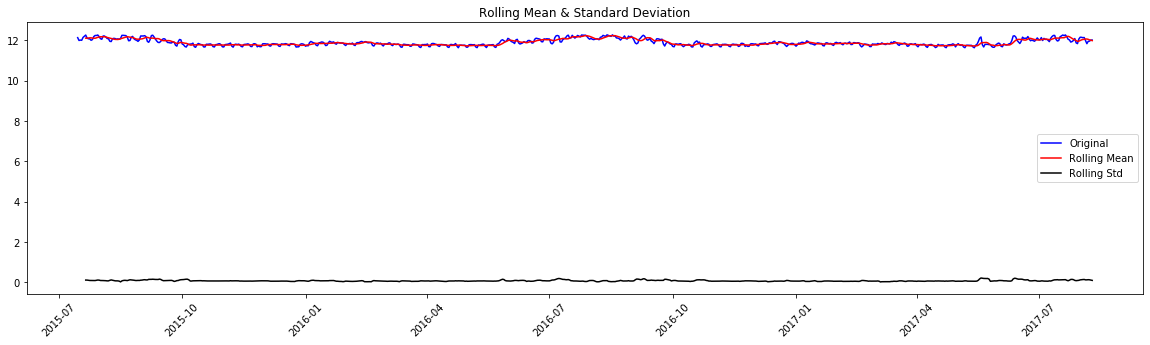

Results of Dickey-Fuller Test:
Test Statistic                  -2.333223
p-value                          0.161477
#Lags Used                      20.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


In [12]:
# if the timeseries is not stationary, check if its differencing, or moving average, or log is stationary
#   differencing is typically used to stabilize non-constant mean
#   log transform is typically used to stabilize non-constant variance
# this is just an example, not necessary if the timeseries is already stationary
dfall['log'] = np.log(dfall[target_column_name])
utils.plot_transformed_data(org = dfall[target_column_name], transform = dfall['log'], series = target_column_name, trans = 'log') 
utils.test_stationarity(dfall['log'], freq=frequency)

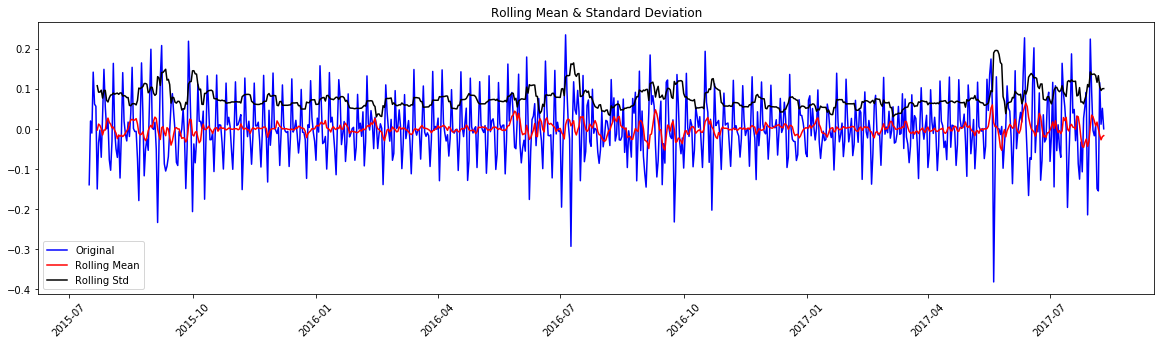

Results of Dickey-Fuller Test:
Test Statistic                -6.573635e+00
p-value                        7.823373e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.360000e+02
Critical Value (1%)           -3.439266e+00
Critical Value (5%)           -2.865475e+00
Critical Value (10%)          -2.568865e+00
dtype: float64


In [13]:
# Data may be still non-stationary after log, take a difference
dfall['logdiff'] = dfall['log'] - dfall['log'].shift()
utils.test_stationarity(dfall['logdiff'].dropna(), freq=frequency)

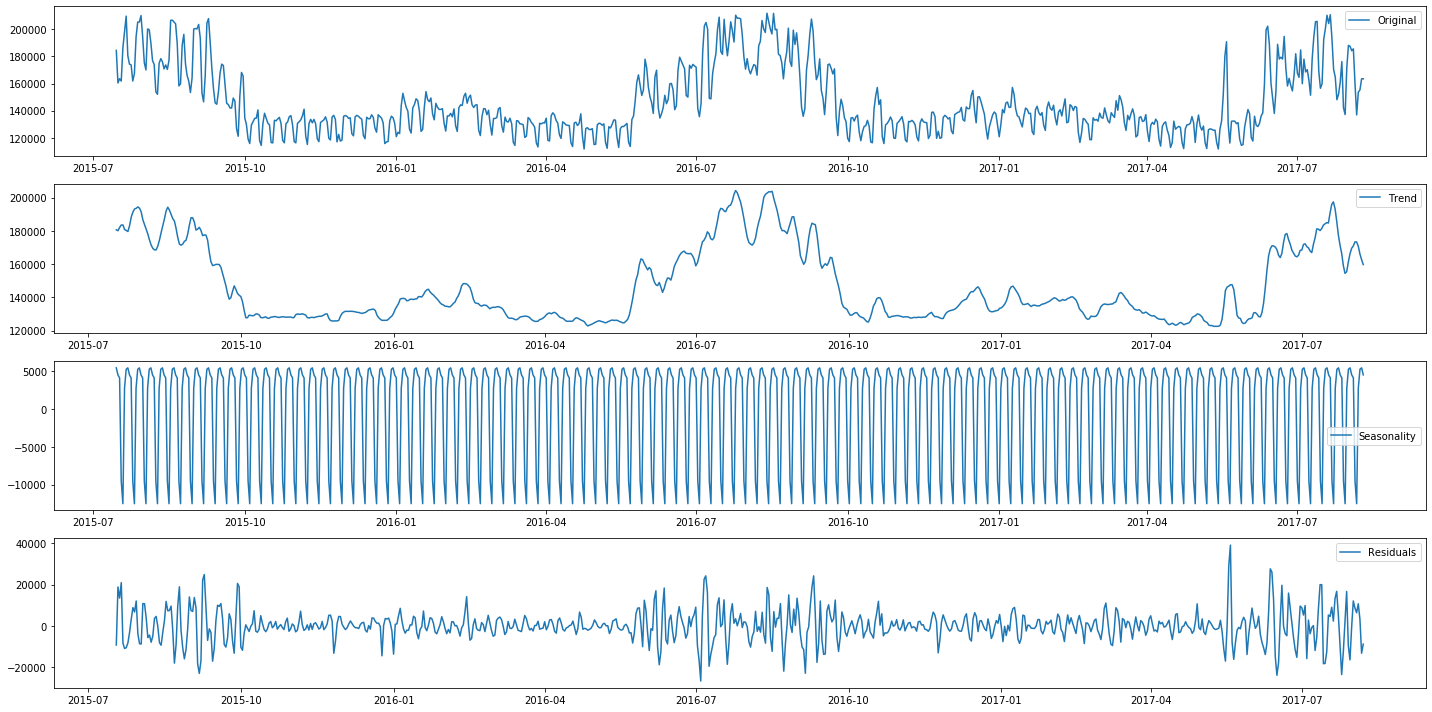

In [14]:
# Another way to examine stationarity is to decompose the timeseries to see if there's trend
decomposition = utils.timeseries_decompose(dfall[target_column_name], frequency)

It's hard to know what timeseries_decompose does to extract the residuals, so it'll be hard to add the trend and seasonality back. We continue to use our log and logdiff.  logdiff can be added by cumulative sum, we must remember the initial value we diff-ed from in order to add it back.  log can be added back by exponent.

In [15]:
dfall.head()

,nycdemand,log,logdiff
dtime,,,
2015-07-15,184384.733,12.124780,NaN
2015-07-16,160374.346,11.985266,-0.139514
2015-07-17,163543.681,12.004835,0.019569
2015-07-18,161812.341,11.994193,-0.010643
2015-07-19,186377.601,12.135530,0.141337


In [16]:
effective_target_column = 'logdiff' #this is the column we are interested in now
dftrain = dfall.loc[training_slice_begin:training_slice_end, [effective_target_column]]
dftrain.dropna(inplace=True)
dftrain.head()

,logdiff
dtime,
2015-07-16,-0.139514
2015-07-17,0.019569
2015-07-18,-0.010643
2015-07-19,0.141337
2015-07-20,0.061615


**-------------------------------------------------------------------------------------**

**End of non-stationary**

 ## Determine ARIMA parameters by examining ACF and PACF
 
The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values.
* p: the first time where ACF crosses the upper confidence level
* q: the first time where PACF crosses the upper confidence level

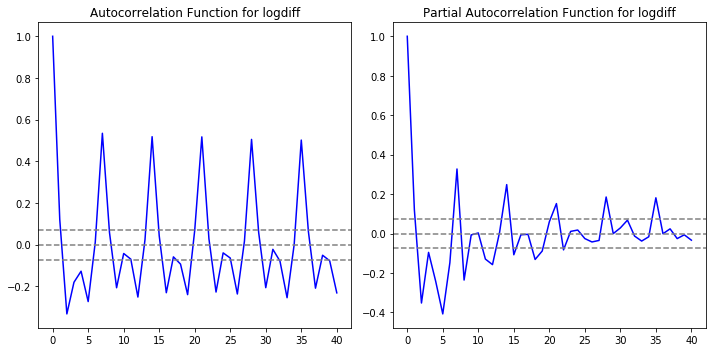

In [17]:
utils.plot_acf_pacf(dfall[effective_target_column].dropna(), effective_target_column) #df_log, df_moving_avg_diff,
# ACF is the amount of correlation between a variable and a lag of itself. 
#   For example hourly data indicates every 24 hours there's a strong positive correlation, every 12 hours there's a strong negative correlation
# PACF is the amount of correlation between a variable and a lag of itself not explained by ACF. 
#   For example PACF of hourly data decays sharply, indicating all correction maybe explained by the low-order lags in ACF. 

We will use the AR model instead of the MA model if there's a sharp decay in ACF, or vice versa. 

                0
count  729.000000
mean     0.000023
std      0.073696
min     -0.388728
25%     -0.034372
50%     -0.005839
75%      0.031078
max      0.226000


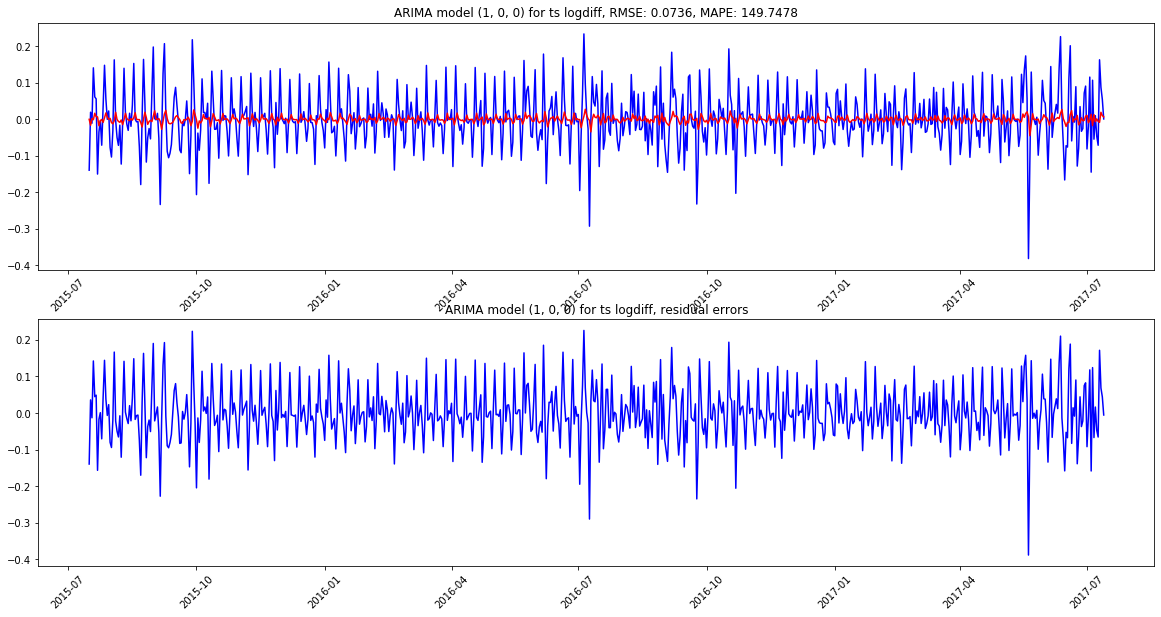

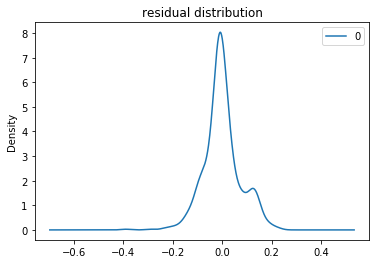

In [18]:
# Ensure there's no trend left in residual errors, and the mean of the error is fairly close to zero
ar = utils.train_arima(dftrain[effective_target_column], effective_target_column, 1, 0, 0)

                0
count  729.000000
mean     0.000042
std      0.072863
min     -0.387182
25%     -0.036004
50%     -0.004220
75%      0.030925
max      0.219964


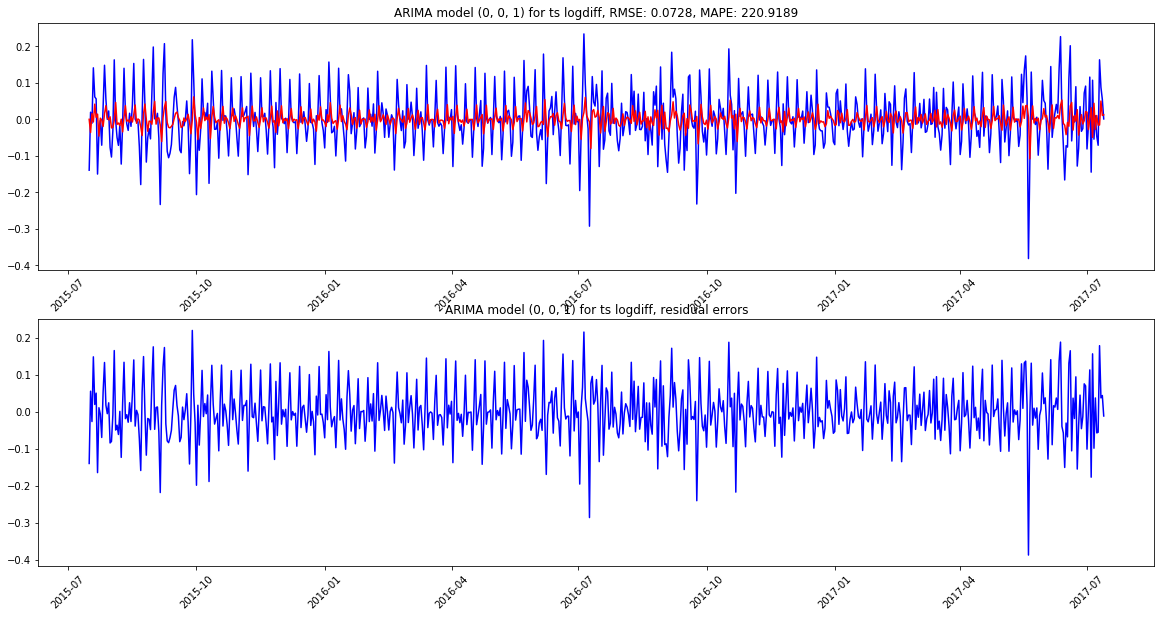

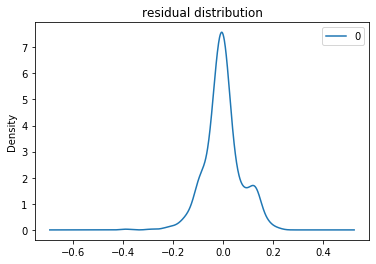

In [19]:
# For testing, we see how MA model performs
# Ensure there's no trend left in residual errors, and the mean of the error is fairly close to zero
ma = utils.train_arima(dftrain[effective_target_column], effective_target_column, 0, 0, 1)

## Use ARIMA to make predictions

First try non-rolling prediction far out in the horizon. 

In [20]:
#y_forecast = ar.predict(start=test_slice_begin, end=test_slice_end) #this returns a series
forecast_array, error, conf = ar.forecast(steps = horizon)
y_forecast = pd.Series(forecast_array).values

**Do this only if data is not stationary and you applied log/diff etc**

**--------------------------------------------------------------------------------------------------**

In [21]:
# Forecast is done on logdiff, we need to put the seasonality and trend back
logdiff_base = dfall.loc[training_slice_end]['log'] 
y_forecast_log = logdiff_base + y_forecast.cumsum()
y_forecast = np.exp(y_forecast_log)

**--------------------------------------------------------------------------------------------------**

**End of non-stationary handling**

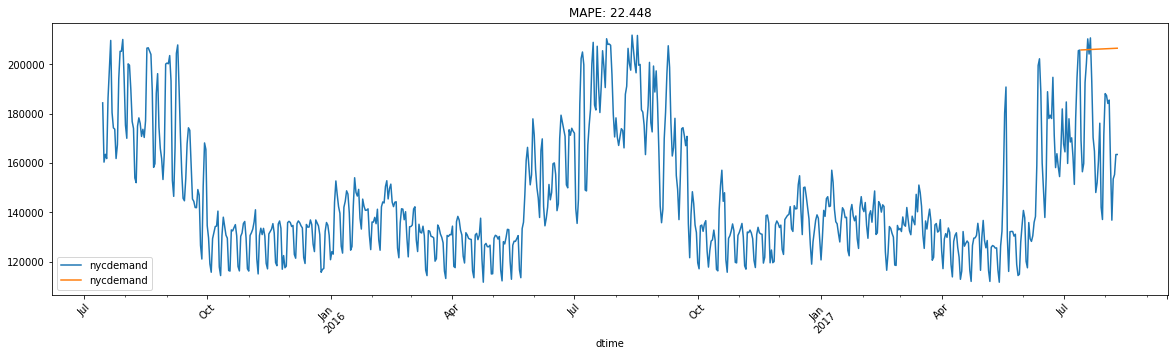

In [22]:
dfforecast = pd.DataFrame(y_forecast, columns={target_column_name}, index=dftest.index)
mape = utils.MAPE(dftest, dfforecast)
pd.concat([dfall[target_column_name], dfforecast], axis=1) \
    .plot(title = 'MAPE: %.3f'% mape, figsize=default_figsize, rot=default_rotation)

## Auto ARIMA

In [23]:
from pyramid.arima import auto_arima

stepwise_model = auto_arima(dftrain[effective_target_column], m=frequency, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

# Akaike information criterion (AIC) value estimates the quality of each model, relative to each other. The lower the better.
print(stepwise_model.aic())

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=-1720.223, BIC=-1711.040, Fit time=0.124 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=-2005.940, BIC=-1987.573, Fit time=0.625 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=-1903.070, BIC=-1884.703, Fit time=0.584 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=-1728.399, BIC=-1714.623, Fit time=0.151 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=-2096.586, BIC=-2073.628, Fit time=2.375 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=-2221.416, BIC=-2193.866, Fit time=3.015 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=-2240.844, BIC=-2217.885, Fit time=2.297 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 7); AIC=-2228.890, BIC=-2201.340, Fit time=2.757 seconds
Fit ARIMA: order=(1, 0, 1) season

In [24]:
stepwise_model.fit(dftrain[effective_target_column])

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

### Forecast on test data

In [25]:
y_forecast = stepwise_model.predict(n_periods=horizon)

**Do this only if data is not stationary and you applied log/diff etc**

**--------------------------------------------------------------------------------------------------**

In [26]:
# Forecast is done on logdiff, we need to put the seasonality and trend back
logdiff_base = dfall.loc[training_slice_end]['log'] 
y_forecast_log = logdiff_base + y_forecast.cumsum()
y_forecast = np.exp(y_forecast_log)

**--------------------------------------------------------------------------------------------------**

**End of non-stationary handling**

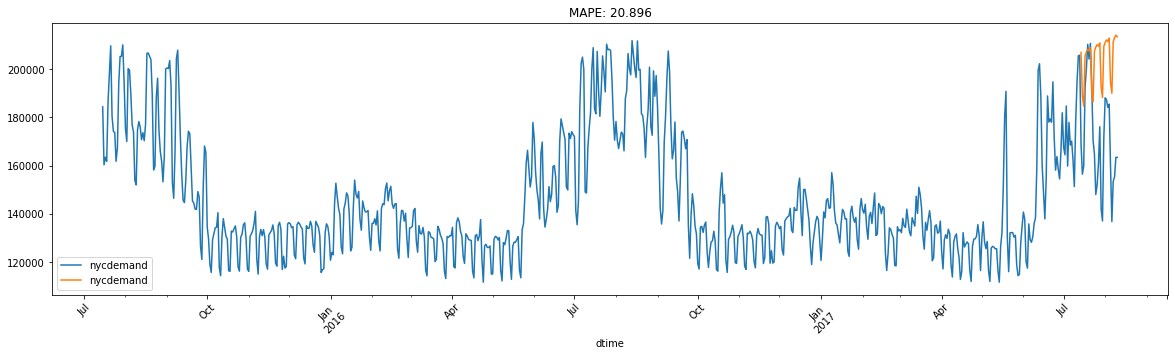

In [27]:
dfforecast = pd.DataFrame(y_forecast, columns={target_column_name}, index=dftest.index)

mape = utils.MAPE(dftest, dfforecast)
pd.concat([dfall[target_column_name], dfforecast], axis=1) \
    .plot(title = 'MAPE: %.3f'% mape, figsize=default_figsize, rot=default_rotation)